In [1]:
import shapely
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [26]:
fire=gpd.read_file(r'full_progression_1219_fireline_spread.shp')

In [27]:
def create_buffer_clip(row):
    '''
    geopandas only allows scale and resolution parameters when creating buffer;
    use this function with pandas.apply to create a flat buffer, and clip the buffer by half with fire line
    '''
    #create flat buffer (150m, 5 pixels)
    buf=row.geometry.buffer(150,resolution=1,cap_style=2)
    #split buffer by half with the fire line
    pol_buffer=shapely.geometry.MultiPolygon(shapely.ops.split(buf,row.geometry))
    return pol_buffer


In [28]:
#fire_buf=test.geometry.buffer(5,resolution=1)
fire_buf=fire.apply(create_buffer_clip,axis=1)

In [29]:
#convert to geo series
fire_buf=gpd.GeoSeries(fire_buf)
fire_buf

0        MULTIPOLYGON (((121035.297 -55531.009, 121034....
1        MULTIPOLYGON (((120572.416 -54782.783, 120706....
2        MULTIPOLYGON (((120847.958 -54619.945, 120779....
3        MULTIPOLYGON (((121009.889 -54607.529, 121007....
4        MULTIPOLYGON (((121184.669 -54678.293, 121117....
                               ...                        
32238    MULTIPOLYGON (((124862.361 -195545.849, 124717...
32239    MULTIPOLYGON (((124423.274 -195583.022, 124500...
32240    MULTIPOLYGON (((124458.013 -195976.937, 124318...
32241    MULTIPOLYGON (((124872.013 -195914.557, 124722...
32242    MULTIPOLYGON (((124320.370 -196072.649, 124318...
Length: 32243, dtype: geometry

In [30]:
fire_buffer=fire.copy()
fire_buffer['geometry']=fire_buf

In [128]:
fire_buffer=fire_buffer.explode()

In [133]:
fire_buffer=fire_buffer.rename_axis(['line_num','buffer_num']).reset_index()

In [172]:
fire_perimeter=gpd.read_file(r'./../progression/Full_progression_1219_052720.shp')

In [66]:
def middle_angle(p1,p2):
    '''
    takes two centroid and calculate the slope of the line connecting their mid-points
    the direction is based on centroid 1
    p1: the centroid of the fireline
    p2: the centroid of the buffer polygon
    return angle value in degrees (ranges from -180(0)-180, 0 degree indicates east, 180 indicates west, 90 is north,-90 is south)
    '''
    
    #p1=line1.centroid
    #p2=line2.centroid
    
    import math
    
    #use math package
    dy=p2.coords[0][1]-p1.coords[0][1]
    dx=p2.coords[0][0]-p1.coords[0][0]
    angle_mid=math.degrees(math.atan2(dy, dx)) #get radiance and convert to degree

    #use numpy
    #connecting=shapely.geometry.LineString([p1,p2])
    #seg = np.array(connecting)
    #seg = seg[1] - seg[0]
    #angle_mid = np.angle(complex(*(seg)), deg=True)
    
    return angle_mid

In [253]:
#check if the buffer is in the burned side or the unburned side
def check_burn(row_buffer,fire,fire_perimeter):
    '''
    check which buffer is the burned side which is the unburned side
    
    arguments:
    row_buffer: one row from the clipped buffer dataset
    fire: the fireline dataset
    fire_perimeter: the daily burned area dataset
    return:
    1: non-burned buffer
    0: others
    -1: burned area buffer
    '''

    #get the corresponding fire line from the fireline dataset
    row_fire=fire.iloc[row_buffer.line_num,:].copy()
    
    ##label 0 if the fire has only been burned for one day
    #if (row_fire.mid_dir_pr==-999)&(row_fire.mid_dir==-999):
    #    return 0
    #elif row_fire.mid_dir_pr==-999:
    #    #for the first day fireline, compare it with future direction (to be updated with the first day boundary centroid)         
    #    p1=row_fire.geometry.centroid
    #    p2=row_buffer.geometry.centroid
    #    ang=middle_angle(p1,p2)
    #    #compare future, if same direction, return -1
    #    if np.sign(row_fire.mid_dir)==np.sign(ang):
    #        return -1
    #    else:
    #        return 1
     
    p1=row_fire.geometry.centroid
    p2=row_buffer.geometry.centroid
    ang=middle_angle(p1,p2)
    
    #for one day fire and the first day fireline, calculate the direction from line to first day centroid
    if row_fire.mid_dir_pr==-999:         
        first=fire_perimeter.loc[(fire_perimeter.gridcode==row_fire.gridcode)&(fire_perimeter.Name==row_fire.Name),'geometry']
        #get the centroid coordinates of the first day polygon, calculate sepeate centroid for multi-polygons
        #this returns a geoseries, use iloc to get the point geometry
        
        #for multipolygons:
        if first.iloc[0].geom_type == 'MultiPolygon': 
            pol_centroid=[]
            for element in first.geometry.iloc[0]:
                pol_centroid.append(element.centroid)
            pol_centroid=shapely.geometry.MultiPoint(pol_centroid)
        
            #among all these points centroids, find the one nearest to the fire line
            #In the returned tuple, the first item (at index 0) is the geometry of our origin shape 
            #and the second item (at index 1) is the actual nearest geometry from the destination points. 
            p0=shapely.ops.nearest_points(row_fire.geometry, pol_centroid)[1]
            
            #angle from line to the first day burns
            ang0=middle_angle(p1,p0)
            #compare the two angles, if the same sign, then the burned buffer
            if np.sign(ang0)==np.sign(ang):
                return -1
            else:
                return 1
        
        else:
            p0=first.centroid.iloc[0]
            #angle from line to the first day burns
            ang0=middle_angle(p1,p0)
            #compare the two angles, if the same sign, then the burned buffer
            if np.sign(ang0)==np.sign(ang):
                return -1
            else:
                return 1
        
    else:
        #if not equal, the buffer is the burned buffer, return -1; else return 1 for unburned buffer
        if np.sign(row_fire.mid_dir_pr)!=np.sign(ang):
            return -1
        else:
            return 1
    
    
    

In [246]:
#first=fire_perimeter.iloc[0]
first=fire_perimeter.loc[(fire_perimeter.gridcode==292)&(fire_perimeter.Name=='Alder'),:]
#row_fire

In [247]:
first

,Name,gridcode,BurnedArea,Year,time_perce,Elev,Slope,Aspect,TD,mTPI,...,dtree_AllM,area_mean,TPA_mean,dtree_mean,mortality_,TPha_weigh,TPha_MWeig,TPA_Class,TPA_MeanCl,geometry
0,Alder,292,2.245113,2018,0.033333,1749.304816,29.162424,278.756958,0.950941,-97.216518,...,88.357566,3801.702728,5.714286,25.245019,0.169332,78.711005,11.244429,3,1,"POLYGON ((123689.514 -200011.157, 123687.093 -..."


In [242]:
first=fire_perimeter.loc[(fire_perimeter.gridcode==row_fire.gridcode)&(fire_perimeter.Name==row_fire.Name),:]

In [248]:
first=first['geometry']

In [249]:
first

0    POLYGON ((123689.514 -200011.157, 123687.093 -...
Name: geometry, dtype: geometry

In [252]:
first.iloc[0].geom_type

'Polygon'

In [ ]:
fig=first.plot()
p0.plot(ax=fig,color='red')

In [207]:
pol_centroid=[]
for element in first.geometry.iloc[0]:
    print(element.centroid)
    pol_centroid.append(element.centroid)
pol_centroid=shapely.geometry.MultiPoint(pol_centroid)


POINT (-138769.1045738247 242983.498183377)
POINT (-140417.6463076437 240313.8164427667)
POINT (-136688.2062803992 243160.3415340369)


'POINT (-136688.2062803992 243160.3415340369)'

In [193]:
row_buffer=fire_buffer.iloc[0,:].copy()
first=fire_perimeter.loc[(fire_perimeter.gridcode==row_fire.gridcode)&(fire_perimeter.Name==row_fire.Name),:]
#get the centroid coordinates of the first day polygon
p0=first.geometry.centroid.iloc[0]
p0.coords
#angle from line to the first day burns
#ang0=middle_angle(p1,p0)

In [254]:
#apply to the geopandas with the first argument omitted
burn_check=fire_buffer.apply(check_burn,fire=fire,fire_perimeter=fire_perimeter,axis=1)

In [256]:
fire_buffer['buffer_type']=burn_check

In [260]:
fire_buffer.to_file(r"./full_progression_1219_fireline_buffer.shp")

In [255]:
burn_check

0        1
1       -1
2       -1
3        1
4        1
        ..
64125   -1
64126   -1
64127    1
64128    1
64129   -1
Length: 64130, dtype: int64

### Update type 0 and first day buffer 
(compare line->buffer centroid with the angle of line->centroid of the whole first day perimeter)

Example Maps

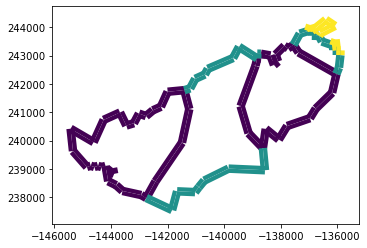

In [50]:
fire_buffer.iloc[33:125,:].plot(column='gridcode')

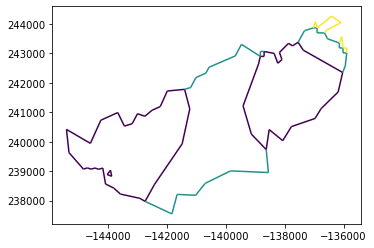

In [49]:
fire.iloc[33:125,:].plot(column='gridcode')

In [51]:
fire.iloc[33:125,:]

,old_id,new_id,FID_Full_p,Name,gridcode,BurnedArea,Year,time_perce,front_len,hd_dist,mid_dist,mid_dir,hd_dist_pr,mid_dist_p,mid_dir_pr,geometry
33,9,0,542,Panther,121,1530.487514,2013,0.333333,3513.780793,784.155575,714.239868,-66.120154,0.000000,0.000000,-999.000000,"LINESTRING (-138633.377 239731.801, -139137.72..."
34,9,1,542,Panther,121,1530.487514,2013,0.333333,3513.780793,1679.005102,1552.771745,-63.924263,0.000000,0.000000,-999.000000,"LINESTRING (-139137.727 240257.335, -139420.16..."
35,9,2,542,Panther,121,1530.487514,2013,0.333333,3513.780793,1667.053875,1257.722994,140.772245,0.000000,0.000000,-999.000000,"LINESTRING (-139420.169 241215.046, -138894.47..."
36,9,3,542,Panther,121,1530.487514,2013,0.333333,3513.780793,266.507373,215.425488,81.596053,0.000000,0.000000,-999.000000,"LINESTRING (-138894.478 242641.663, -138834.37..."
37,10,0,542,Panther,121,1530.487514,2013,0.333333,1973.721575,344.752764,235.603436,172.194357,0.000000,0.000000,-999.000000,"LINESTRING (-138703.836 243065.692, -138364.66..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,31,1,544,Panther,123,28.084417,2013,1.000000,1699.411290,0.000000,0.000000,-999.000000,714.936901,660.396959,57.964596,"LINESTRING (-136411.326 244265.617, -136086.69..."
121,31,2,544,Panther,123,28.084417,2013,1.000000,1699.411290,0.000000,0.000000,-999.000000,664.256981,413.774867,51.128489,"LINESTRING (-136086.691 244049.538, -136592.58..."
122,31,3,544,Panther,123,28.084417,2013,1.000000,1699.411290,0.000000,0.000000,-999.000000,223.010256,147.593451,98.522193,"LINESTRING (-136592.582 243790.246, -136649.78..."
123,32,0,544,Panther,123,28.084417,2013,1.000000,294.296288,0.000000,0.000000,-999.000000,127.688803,127.688803,-0.965688,"LINESTRING (-136019.896 243186.637, -135892.22..."


In [ ]:
#shapely.ops.split(test.iloc[5,:].geometry.buffer(5,resolution=1,cap_style=2),test.iloc[5,:].geometry).wkt
#shapely.geometry.MultiPolygon(shapely.ops.split(fire_buf[5],test.iloc[5,:].geometry)).wkt

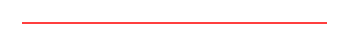

In [96]:

f, ax = plt.subplots(1)
#gpd.GeoSeries(test.iloc[5,:].geometry.buffer(30,resolution=1,cap_style=2)).plot(ax=ax)
#gpd.GeoSeries(test.iloc[5,:].geometry).plot(ax=ax,color='red')
#gpd.GeoSeries(row_buffer.geometry[0]).plot(ax=ax)
#gpd.GeoSeries(row_buffer.geometry[1]).plot(ax=ax,color='green')
gpd.GeoSeries(shapely.geometry.LineString([p1,p2])).plot(ax=ax,color='red')
ax.set_axis_off()
plt.show()

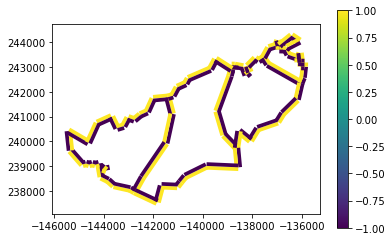

In [257]:
fire_buffer.iloc[66:250,:].plot(column='buffer_type',legend=True)

In [170]:
fire_buffer.iloc[66:67,:]

,line_num,buffer_num,old_id,new_id,FID_Full_p,Name,gridcode,BurnedArea,Year,time_perce,front_len,hd_dist,mid_dist,mid_dir,hd_dist_pr,mid_dist_p,mid_dir_pr,geometry,buffer_type
66,33,0,9,0,542,Panther,121,1530.487514,2013,0.333333,3513.780793,784.155575,714.239868,-66.120154,0.0,0.0,-999.0,"POLYGON ((-139245.952 240153.472, -139137.727 ...",-1


In [261]:
pier=fire_perimeter.loc[fire_perimeter['Name']=='Pier',:]
lion=fire_perimeter.loc[fire_perimeter['Name']=='Lion',:]

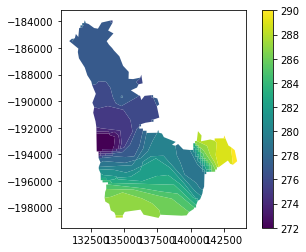

In [263]:
lion.plot(column='gridcode',legend=True)

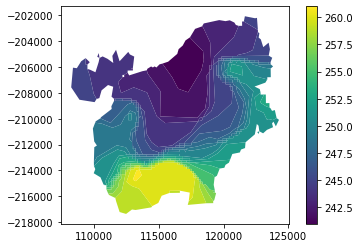

In [264]:
pier.plot(column='gridcode',legend=True)

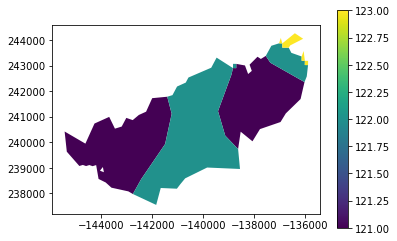

In [265]:
Panther=fire_perimeter.loc[fire_perimeter['Name']=='Panther',:]
Panther.plot(column='gridcode',legend=True)